# Fitting Gaussian Mixture Model with Expectatoin Maximization Algorithm

In this notebook, we implement the process of fitting Gaussian mixture models using the expectatoin maximization (EM) algorithm. 

Note : I have not followed any convergence proof of the EM algorithm, and do not know whether the parameter set obtained by the EM algorithm is indeed a local maximum. Hence, the treatment in the notebook is non rigoirous. 
It seems that the following paper discusses these points: 

Wu, C. F. Jeff (Mar 1983). "On the Convergence Properties of the EM Algorithm". Annals of Statistics. 11 (1): 95-103.
https://projecteuclid.org/euclid.aos/1176346060

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib as mpl
from matplotlib import pyplot as plt
import time

%matplotlib inline
mpl.rc("savefig",dpi=100)

## 1. Theory 

Here we briefly summarize the analytical results needed. 
For the derivation, please see the book.

### 1.1 Model

Let 
* $N \in \mathbb{N}$ be the number of data points, and
* $d \in \mathbb{N}$ be the input dimension.

Then, 
a Gaussian mixture model with $K  \in \mathbb{N}$ components for the $N$ data points is defined by
\begin{eqnarray}
    p\left(X,Z \middle| \mu, \Sigma, \pi \right) = 
    \prod_{n=0}^{N-1} \prod_{k=0}^{K-1} 
    \left[\pi_k \mathcal{N}\left(x_n \middle| \mu_k , \Sigma_k \right) \right]^{z_{n,k}}
\end{eqnarray}
where 
* $X = (x_{n,k})_{ n \in \{ 0, 1, \dots, N-1 \} k \in \{ 0,1, \dots, K-1 \}  }, \ x_{n,k}\in \mathbb{R}^d$ is the matrix that stands for data points, 
* $Z = (z_{n,k})_{ n \in \{ 0, 1, \dots, N-1 \} k \in \{ 0,1, \dots, K-1 \}  }, \ z_{n,k}\in \{0,1 \}, \sum_{k=0}^{K-1}z_{n,k}=1$, is the matrix that stands for latent variables, 
* $\pi_k \geq 0, \sum_{k=0}^{K-1} \pi_k = 1$, and   
* $\mathcal{N}\left(x \middle| \mu_k , \Sigma_k \right)$ is a gaussian probability density with mean $\mu_k \in \mathbb{R}^d$ and covariance matrix $\Sigma_k$.

### 1.2 Goal

Our goal is to obtain a tuple of parameter $(\mu, \Sigma, \pi)$ which "maximizes" the likelihood $\log p(X|\mu, \Sigma, \pi)$. 

Note that, as was discussed in detail in Section 9.2.1 of the book, this maximization procedure is ill-posed, and hence we expect that we obtain a parameter set that locally maximizes the likelihood. 

### 1.3 Algorithm


1. Initialize parameters. 
2. E step : Calculate the responsibility $\gamma_{n,k}$ by 
\begin{equation}
    \gamma_{n,k} = \frac{ \pi_{k} \mathcal{N}\left(x_n \middle| \mu_k , \Sigma_k \right)   }{ \sum_{l=0}^{K-1} \pi_{l} \mathcal{N}\left(x_n \middle| \mu_l , \Sigma_l \right)  }
\end{equation}
3. M step : Using the responsibility obtained in the previous step, calculate the new parameters by 
\begin{eqnarray}
    &{}& N_k = \sum_{n=0}^{N-1} \gamma_{n,k} \\
    &{}& \pi_k = \frac{N_k}{N}\\
    &{}& \mu_k = \frac{1}{N_k} \sum_{n=0}^{N-1} \gamma_{n,k} x_n \\
    &{}& \Sigma_k = \frac{1}{N_k} \sum_{n=0}^{N-1} \gamma_{n,k} (x_n-\mu_k)(x_n-\mu_k)^T  \\
\end{eqnarray}
4. Repeat 2 and 3 until the parameter set converges.

## 2. From math to code

Here we show how we can convert the equations shown above into codes, emphasizing vectorized implementations.

### 2.1 Arrays
* X : (N,d) array stands for input data
* Pi : (K) array, where Pi[k] = $\pi_k$
* M : (K,d) array, where M[k,i] = $\mu_{k,i}$
* S : (K, d, d) array, where S[k,i,j] = $\left( \Sigma_{k} \right)_{i,j}$
* L : (K,d,d) array, where L[k,i,j] = $\left( \Sigma_{k}^{-1} \right)_{i,j} $
* D : (N,K, d) array, where D[n,k,i] = $x_{n,i} - \mu_{k,i}$, where $D$ stands for the initial of "difference".
* Gam : (N,K) array, where Gam[n,k] = $\gamma_{n,k}$
* Nmat : (N,K) array, where Nmat[n,k] = $\mathcal{N}\left(x_n \middle| \mu_k, \Sigma_k \right)$

### 2.2 Calculation

#### E-step

We have
\begin{eqnarray}
    &{}& Nmat_{n,k} = \frac{1}{\sqrt{\det S_{k}}}exp\left( -\frac{1}{2} \sum_{i,j=1}^{d} D_{n,k,i} L_{k,i,j} D_{n,k,j} \right) \\
    &{}& Gam_{n,k} = \frac{Nmat_{n,k} Pi_k}{ \sum_{l=1} Nmat_{n,l} Pi_l}
\end{eqnarray}
To vectorize the summation, numpy.einsum function will be used
(For detail, see https://docs.scipy.org/doc/numpy/reference/generated/numpy.einsum.html ).
Also, note that the inverses of several matrices can be computed at once by numpy.linalg.inv (See https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.inv.html ). 
Same statement applies to determinant( https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.det.html ).

#### M-step

\begin{eqnarray}
    &{}& Pi_k = \frac{1}{N} \sum_{n=0}^{N-1}Gam_{n,k} \\
    &{}& M_{k,i} = \frac{1}{N_k} \sum_{n=0}^{N-1} Gam_{n,k} X_{n,i} \\
    &{}& S_{k,i,j} = \frac{1}{N_k} \sum_{n=0}^{N-1} Gam_{n,k} D_{n,k,i} D_{n,k,j}
\end{eqnarray}

#### Initializing parameters

We set initial values of parameters as follows:
* $\pi$: random positive vector normalized to one, 
* $\mu$: $K$ vectors randomly chosen from the input data points, and
* $\Sigma$: $[\sigma^2 I_d, \dots, \sigma^2 I_d]$, where $I_d$ is the $d$ dimensional identity matrxi and $\sigma^2$ is the variance of the input data. 

## 3. Code

In [2]:
class Gaussian_mixture_model:
    def __init__(self,d,K):
        self.K = K
        self.d = d
        
        # data
        self.X = None
        self.N = None
        
        # Model parameters
        self.Pi = None
        self.M = None
        self.S = None
        
    def load_dat(self,Xmat):
        if len(Xmat[0]) != self.d:
            print("Error: Input dimension is inconsistent.")
        else:
            self.X = Xmat
            self.N = len(Xmat)
        
    def init_params(self):
        # initializing pi. The "+0.1" term is added to ensure that all the elements are positive.
        tmp = np.random.rand(self.K) + 0.1
        self.Pi = tmp/np.sum(tmp)
        # initializing M
        ind = np.random.randint(0, self.N, self.K)
        self.M = Xdat[ind]
        # initializing S
        vardat = np.var(Xdat,axis=0)
        self.S = np.tile(vardat*np.eye(self.d), (self.K,1,1))
        
    # Calculate Nmat
    def calc_nmat(self,Xmat):
        ## 1. Calculate D, where D[n,k,i] = $x_{n,i} - \mu_{k,i}$, utilizing numpy broadcasting
        D = np.reshape(Xmat, (len(Xmat),1,self.d) ) - np.reshape(self.M, (1, self.K, self.d) )
        ## 2. Obtain the array of precision matrix
        L = np.linalg.inv(self.S)
        ## 3. Obtain the exponential factor
        tmp = np.einsum("nkj,nkj->nk",np.einsum("nki,kij->nkj",D,L),D)
        return np.exp(-0.5*tmp)/np.sqrt(np.linalg.det(self.S))   / (2*np.pi)**(self.d/2)
        
    def Estep(self):
        Nmat = self.calc_nmat(self.X)
        tmp = Nmat * self.Pi
        Gam = tmp/np.reshape(np.sum(tmp,axis=1),(self.N,1) )
        return Gam
        
    def Mstep(self, Gam):
        D = np.reshape(self.X, (len(self.X),1,self.d) ) - np.reshape(self.M, (1, self.K, self.d) )
        Nk = np.sum(Gam,axis=0)
        self.Pi = Nk/self.N
        self.M = Gam.T @ self.X / np.reshape(Nk,(self.K,1))
        self.S = np.einsum("nki,nkj->kij", np.einsum("nk,nki->nki", Gam, D), D) / np.reshape(Nk,(self.K, 1, 1))
        
    def fit(self,Xmat, max_iter, tol, disp_message):
        self.load_dat(Xmat)
        self.init_params()
        
        for i in range(max_iter):
            Pi_tmp = self.Pi; M_tmp = self.M; S_tmp = self.S
            Gam = self.Estep()
            self.Mstep(Gam)
            err = np.array([np.linalg.norm(self.Pi - Pi_tmp), np.linalg.norm(self.M - M_tmp), np.linalg.norm(self.S - S_tmp)])
            if all(err < tol):
                break
        if disp_message:
            print(f"n_iter : {i}")
            print(f"Change in parameters : {np.max(err)}")

## 4. Experiment

Here is a toy example, in which data is generated from a Gaussian mixture distribution.

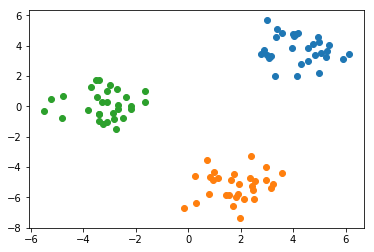

In [3]:
K = 3 # the number of components
NK = 30  # the number of data points for each component
Xdat = np.zeros((NK*K,2))
mus = np.array([[4,4],[2,-5],[-3,0]])

for k in range(K):
    Xdat[NK*k:NK*k+NK] = np.random.multivariate_normal(mean=mus[k],cov=np.eye(2),size=NK)

# mesh, which will be used for plotting later
xx = np.linspace(np.min(Xdat[:,0]),np.max(Xdat[:,0]),101)
yy = np.linspace(np.min(Xdat[:,1]),np.max(Xdat[:,1]),100)
Xtest = np.array([[x,y] for x in xx  for y in yy])
xxx,yyy = np.meshgrid(xx,yy)

for k in range(K):
    plt.plot(Xdat[NK*k:NK*k+NK,0],Xdat[NK*k:NK*k+NK,1],'o')
plt.show()

If we choose $K=3$ for the model, we can fit the data as follows:

n_iter : 13
Change in parameters : 8.432884306271573e-07


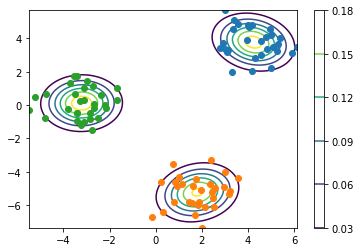

In [4]:
gmm = Gaussian_mixture_model(d=2,K=3)
gmm.fit(Xdat, max_iter=30, tol=1e-4, disp_message=True)

prob = np.sum(gmm.calc_nmat(Xtest),axis=1)
prob_2D = np.reshape(prob,(len(xx),len(yy))).T

plt.contour(xxx,yyy,prob_2D)
plt.colorbar()

for k in range(K):
    plt.plot(Xdat[NK*k:NK*k+NK,0],Xdat[NK*k:NK*k+NK,1],'o')

The result for various $K$ are shown below.

n_iter : 2
Change in parameters : 0.0
n_iter : 9
Change in parameters : 1.0935648334800331e-09
n_iter : 7
Change in parameters : 1.788511741343365e-09
n_iter : 96
Change in parameters : 8.894654233625906e-05


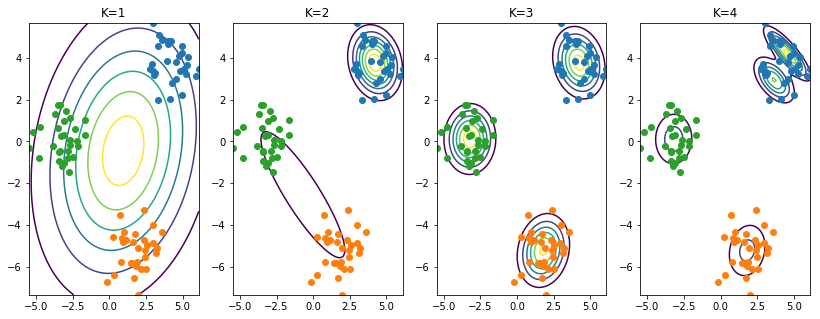

In [5]:
plt.figure(figsize=(14,5))
for K in range(1,5,1):
    gmm = Gaussian_mixture_model(d=2,K=K)
    gmm.fit(Xdat, max_iter=100, tol=1e-4, disp_message=True)
    
    prob = np.sum(gmm.calc_nmat(Xtest),axis=1)
    prob_2D = np.reshape(prob,(len(xx),len(yy))).T
        
    plt.subplot(1,4,K)
    plt.contour(xxx,yyy,prob_2D)
    for k in range(3):
        plt.plot(Xdat[NK*k:NK*k+NK,0],Xdat[NK*k:NK*k+NK,1],'o')
    plt.title(f"K={K}")